In [135]:
import numpy as np
import os

### functions

In [136]:
def split_covid_data(arr_path, normalize=True):
    covid_data = np.load(arr_path)
    covid_data = covid_data.astype(np.float32)
    
    if normalize: 
        data_mean = np.mean(covid_data, axis=1, keepdims=True)
        data_std = np.std(covid_data, axis=1, keepdims=True)
        covid_data = (covid_data - data_mean) / data_std
        stats_train = (data_mean[:709,:], data_std[:709,:])
        stats_val = (data_mean[709:798, :], data_std[709:798, :])
        stats_test = (data_mean[798:, :], data_std[798:,:])
        stats = (stats_train, stats_val, stats_test)
    else: 
        stats = None
    
    train_data = covid_data[:709,:]
    val_data = covid_data[709:798,:]
    test_data = covid_data[798:, :]

    # reshaping arrays:
    train_data = np.reshape(train_data, newshape=(train_data.shape[0], train_data.shape[1], 1))
    val_data = np.reshape(val_data, newshape=(val_data.shape[0], val_data.shape[1], 1))
    test_data = np.reshape(test_data, newshape=(test_data.shape[0], test_data.shape[1], 1))

    return train_data, val_data, test_data, stats

In [137]:
def rescale_covid_data(data_sample, stats, index):
    data_mean, data_std = stats
    mean, std = data_mean[index], data_std[index]
    data_sample = std * data_sample + mean
    data_sample = data_sample.astype(np.int32)
    return data_sample

In [138]:
covid_path = '../../data/covid_preprocess.npy'
train_data, val_data, test_data, stats = split_covid_data(covid_path)
stats_train, stats_val, stats_test = stats
train_data_unnorm, val_data_unnorm, test_data_unnorm, _ = split_covid_data(covid_path, normalize=False)

In [139]:
sum_test_data = np.sum(test_data_unnorm, axis=1)
print(np.max(sum_test_data))
print(np.argmax(sum_test_data))

20504.0
33


In [182]:
print(list(np.sort(sum_test_data)))

[array([679.], dtype=float32), array([101.], dtype=float32), array([5996.], dtype=float32), array([164.], dtype=float32), array([127.], dtype=float32), array([182.], dtype=float32), array([387.], dtype=float32), array([3608.], dtype=float32), array([460.], dtype=float32), array([116.], dtype=float32), array([863.], dtype=float32), array([310.], dtype=float32), array([102.], dtype=float32), array([221.], dtype=float32), array([1241.], dtype=float32), array([141.], dtype=float32), array([107.], dtype=float32), array([808.], dtype=float32), array([260.], dtype=float32), array([155.], dtype=float32), array([472.], dtype=float32), array([283.], dtype=float32), array([135.], dtype=float32), array([237.], dtype=float32), array([521.], dtype=float32), array([437.], dtype=float32), array([497.], dtype=float32), array([1890.], dtype=float32), array([249.], dtype=float32), array([893.], dtype=float32), array([401.], dtype=float32), array([131.], dtype=float32), array([414.], dtype=float32), array

In [178]:
print(list(test_data_unnorm[2].reshape(61)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 9.0, 16.0, 19.0, 20.0, 20.0, 20.0, 20.0, 21.0, 31.0, 37.0, 37.0, 37.0, 37.0, 37.0, 66.0, 76.0, 85.0, 90.0, 95.0, 100.0, 114.0, 124.0, 134.0, 137.0, 153.0, 184.0, 198.0, 201.0, 206.0, 211.0, 227.0, 230.0, 239.0, 243.0, 253.0, 262.0, 267.0, 273.0, 278.0, 282.0, 284.0, 292.0, 302.0]


In [140]:
index = 88
N = 10
N2 = 100

In [184]:
smc_t_10_p_path = '../../output/covid_SMC_T/covid_smc_t_10_p'
smc_t_60_p_path = '../../output/covid_SMC_T/covid_smc_t_60_p'

lstm_path_1 = '../../output/covid_rnn/covid_LSTM_64_pdrop_0.1_rnndrop_0.0'
lstm_path_2 = '../../output/covid_rnn/covid_LSTM_64_pdrop_0.2_rnndrop_0.2'
lstm_path_5 = '../../output/covid_rnn/covid_LSTM_64_pdrop_0.5_rnndrop_0.0'

In [142]:
mean_preds_10_p_path = os.path.join(smc_t_10_p_path, 'mean_preds_sample_{}_N_{}.npy'.format(index, N))                              
distrib_10_p_path = os.path.join(smc_t_10_p_path, 'distrib_future_timesteps_sample_{}_N_{}.npy'.format(index, N))

mean_preds_60_p_path = os.path.join(smc_t_60_p_path, 'mean_preds_sample_{}_N_{}.npy'.format(index, N2))                              
distrib_60_p_path = os.path.join(smc_t_60_p_path, 'distrib_future_timesteps_sample_{}_N_{}.npy'.format(index, N2))


In [185]:
mc_drop_1_path = os.path.join(lstm_path_1, 'mc_dropout_samples_sample_{}.npy'.format(index))
mc_drop_2_path = os.path.join(lstm_path_2, 'mc_dropout_samples_sample_{}.npy'.format(index))
mc_drop_5_path = os.path.join(lstm_path_5, 'mc_dropout_samples_sample_{}.npy'.format(index))

In [144]:
#mean_preds_path = os.path.join(smc_t_path, mean_preds_sample_{}_N_{}_multi.npy'.format(index, N))
#distrib_path = os.path.join(smc_t_path, distrib_future_timesteps_sample_{}_N_{}_multi.npy'.format(index, N))

In [145]:
mean_preds_10 = np.load(mean_preds_10_p_path)
distrib_10 = np.load(distrib_10_p_path)
mean_preds_60 = np.load(mean_preds_60_p_path)
distrib_60 = np.load(distrib_60_p_path)

In [146]:
true_labels = test_data_unnorm[index, 1:].reshape(60)
mean_preds_rescaled_10 = rescale_covid_data(mean_preds_10, stats=stats_test, index=index)
distrib_rescaled_10 = rescale_covid_data(distrib_10, stats=stats_test, index=index)
mean_preds_rescaled_60 = rescale_covid_data(mean_preds_60, stats=stats_test, index=index)
distrib_rescaled_60 = rescale_covid_data(distrib_60, stats=stats_test, index=index)

### Plots SMC Transformer

In [147]:
import matplotlib.pyplot as plt

In [148]:
x = np.linspace(1,60,60)

In [171]:
def plot_means(title, x, true_labels, mean_preds_rescaled_10, mean_preds_rescaled_60=None):
    fig, ax = plt.subplots(figsize=(16,8))
    ax.plot(x, true_labels, '-', label='true data', color='tab:grey')
    ax.plot(x, mean_preds_rescaled_10, 'o', color='tab:brown', label ='mean predictions - 10 particules')
    if mean_preds_rescaled_60 is not None:
        ax.plot(x, mean_preds_rescaled_60, 'x', color='tab:orange', label = 'mean predictions - 60 particules')
    ax.set_xlabel('number of days')
    ax.set_ylabel('daily deaths')
    ax.set_title(title)
    ax.legend()
    return fig, ax

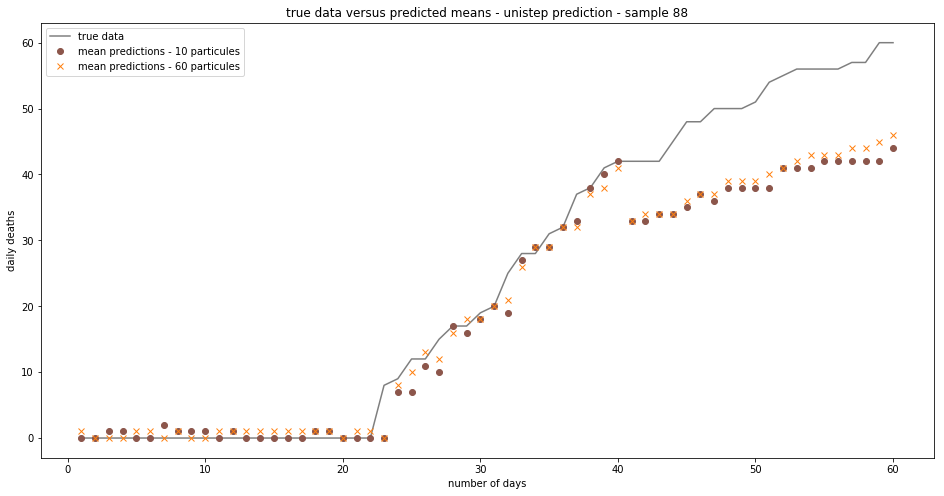

In [172]:
title = 'true data versus predicted means - unistep prediction - sample {}'.format(index)
fig, ax = plot_means(title, x, true_labels, mean_preds_rescaled_10, mean_preds_rescaled_60)

### confidence intervals computation

In [151]:
def get_distrib_stats(distrib_rescaled):
    distrib_mean = np.mean(distrib_rescaled, axis=1)
    print(distrib_mean[0])
    distrib_std = np.std(distrib_rescaled, axis=1)
    print(distrib_std[0])
    distrib_max = np.max(distrib_rescaled, axis=1)
    distrib_min = np.min(distrib_rescaled, axis=1)
    return distrib_mean, distrib_std, distrib_max, distrib_min

In [152]:
def pad_array(array):
    pad_distrib = np.zeros(shape=60)
    pad_distrib[40:] = array
    return pad_distrib

In [153]:
def get_errors(distrib_mean, distrib_std, distrib_max, distrib_min):
    pad_distrib_mean = pad_array(distrib_mean)
    pad_distrib_std = pad_array(distrib_std)
    lower_bound_min = pad_array(distrib_min)
    upper_bound_max = pad_array(distrib_max)
    lower_bound = pad_distrib_mean - 1.960 * pad_distrib_std / (1000**(1/2))
    upper_bound = pad_distrib_mean + 1.960 * pad_distrib_std / (1000**(1/2))
    #lower_bound = pad_distrib_mean - 1.960 * pad_distrib_std
    #upper_bound = pad_distrib_mean + 1.960 * pad_distrib_std
    return lower_bound, upper_bound, lower_bound_min, upper_bound_max

In [154]:
mean_10, std_10, max_10, min_10 = get_distrib_stats(distrib_rescaled_10)
mean_60, std_60, max_60, min_60 = get_distrib_stats(distrib_rescaled_60)
lb_10, ub_10, lb_min_10, lb_max_10 = get_errors(mean_10, std_10, max_10, min_10)
lb_60, ub_60, lb_min_60, lb_max_60 = get_errors(mean_60, std_60, max_60, min_60)

33.493
4.316011005546673
33.434
3.8963629194416685


In [155]:
ci_10 = [lb_10, ub_10]
min_max_10 = [lb_min_10, lb_max_10]
ci_60 = [lb_60, ub_60]
min_max_60 = [lb_min_60, lb_max_60]

In [165]:
def plot_inference_smc_t(title, x, true_labels, mean_preds_10, ci_10, min_max_10, mean_preds_60=None, ci_60=None, min_max_60=None):
    fig, ax = plt.subplots(figsize=(16,8))
    ax.plot(x, true_labels, '-', label='true data')
    
    ax.plot(x, mean_preds_10, '-', linestyle='dashed', color='tab:brown', label='mean predicted data - 10 particules')
    ax.fill_between(x, min_max_10[0], min_max_10[1], alpha=0.2, color='tab:brown')
    ax.fill_between(x, ci_10[0], ci_10[1], alpha=0.5, color='tab:red')
    
    if mean_preds_60 is not None:
        ax.plot(x, mean_preds_60, '-', linestyle='dashed', color='tab:orange', label='mean predicted data - 60 particules')
        ax.fill_between(x, min_max_60[0], min_max_60[1], alpha=0.2, color='tab:orange')
        ax.fill_between(x, ci_60[0], ci_60[1], alpha=0.5, color='tab:green')

    ax.set_xlabel('number of days')
    ax.set_ylabel('number of deaths')
    ax.set_title(title)
    ax.legend()
    return fig, ax

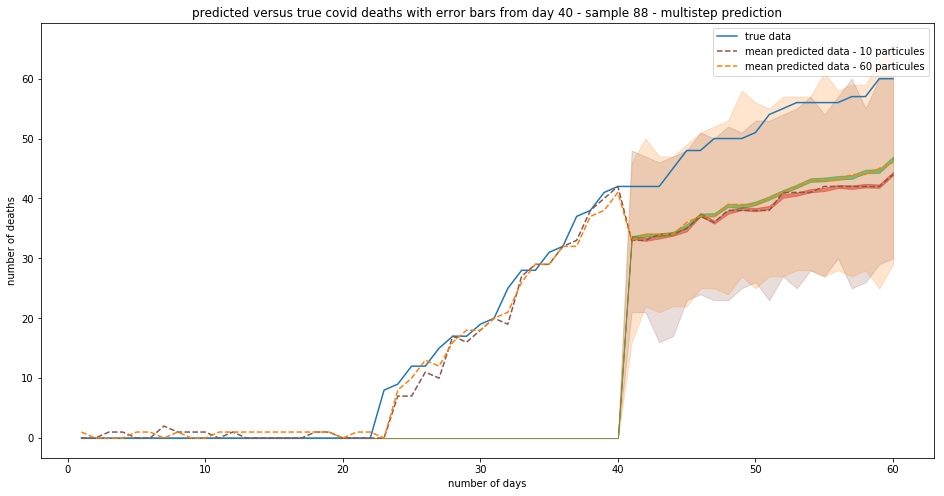

In [166]:
title = "predicted versus true covid deaths with error bars from day 40 - sample {} - multistep prediction".format(index)
fig, ax = plot_inference_smc_t(title, x, true_labels, mean_preds_rescaled_10, ci_10, min_max_10, mean_preds_rescaled_60, ci_60, min_max_60)

In [114]:
save_path = 'unistep_prediction_sample_{}_N_{}_10p_60p'.format(index, N)
fig_path = os.path.join(smc_t_10_p_path, save_path)
#fig.savefig(fig_path)

### adding mc dropout

In [188]:
mc_samples_1 = np.load(mc_drop_1_path)
mc_samples_2 = np.load(mc_drop_2_path)
mc_samples_5 = np.load(mc_drop_5_path)

In [192]:
mc_samples_1.shape

(1000, 60)

In [194]:
mc_samples_1 = rescale_covid_data(data_sample=mc_samples_1, stats=stats_test, index=index)
mc_samples_2 = rescale_covid_data(data_sample=mc_samples_2, stats=stats_test, index=index)
mc_samples_5 = rescale_covid_data(data_sample=mc_samples_5, stats=stats_test, index=index)
mc_samples_1 = mc_samples_1.reshape(60,1000)
mc_samples_2 = mc_samples_2.reshape(60,1000)
mc_samples_5 = mc_samples_5.reshape(60,1000)

In [196]:
lstm_preds_1 = np.mean(mc_samples_1, axis=1)
lstm_preds_2 = np.mean(mc_samples_2, axis=1)
lstm_preds_5 = np.mean(mc_samples_5, axis=1)

In [198]:
mc_samples_1 = mc_samples_1[40:, :]
mc_samples_2 = mc_samples_2[40:, :]
mc_samples_5 = mc_samples_5[40:, :]

In [199]:
mean_1, std_1, max_1, min_1 = get_distrib_stats(mc_samples_1)
mean_2, std_2, max_2, min_2 = get_distrib_stats(mc_samples_2)
mean_5, std_5, max_5, min_5 = get_distrib_stats(mc_samples_5)
lb_1, ub_1, lb_min_1, lb_max_1 = get_errors(mean_1, std_1, max_1, min_1)
lb_2, ub_2, lb_min_2, lb_max_2 = get_errors(mean_2, std_2, max_2, min_2)
lb_5, ub_5, lb_min_5, lb_max_5 = get_errors(mean_5, std_5, max_5, min_5)

12493.31
741.3915914683683
12754.01
999.6650348491738
13205.867
1811.8870945263118


In [204]:
ci_1 = [lb_1, ub_1]
int_1 = [lb_min_1, lb_max_1]
ci_2 = [lb_2, ub_2]
int_2= [lb_min_2, lb_max_2]
ci_5 = [lb_5, ub_5]
int_5= [lb_min_5, lb_max_5]

In [1009]:
#mc_mean = np.mean(mc_samples, axis=0)
#mc_std = np.std(mc_samples, axis=0)
#mc_max = np.max(mc_samples, axis=0)
#mc_min = np.min(mc_samples, axis=0)
#pad_mc_mean = pad_array(mc_mean)
#pad_mc_std = pad_array(mc_std)
#pad_mc_max = pad_array(mc_max)
#pad_mc_min = pad_array(mc_min)
#mc_lb = pad_mc_mean - 1.960 * pad_mc_std / (mc_samples.shape[0]**(1/2))
#mc_ub = pad_mc_mean + 1.960 * pad_mc_std / (mc_samples.shape[0]**(1/2))

In [205]:
def plot_mc_dropout(title, x, true_labels, preds_1, ci_1, int_1, preds_2, ci_2, int_2, preds_5, ci_5, int_5):
    fig, ax = plt.subplots(figsize=(16,8))
    ax.plot(x, true_labels, '-', label='true data', color='tab:grey')
    
    ax.plot(x, preds_1, '-', linestyle='dashed', color='tab:blue', label='LSTM predictions - pdrop=0.1')
    ax.fill_between(x, ci_1[0], ci_1[1], alpha=0.1, color='tab:blue')
    ax.fill_between(x, int_1[0], int_1[1], alpha=0.5, color='tab:blue')
    
    ax.plot(x, preds_2, '-', linestyle='dashed', color='tab:green', label='LSTM predictions - pdrop=0.2, rnn_drop=0.2')
    ax.fill_between(x, ci_2[0], ci_2[1], alpha=0.1, color='tab:green')
    ax.fill_between(x, int_2[0], int_2[1], alpha=0.5, color='tab:green')
    
    
    
    ax.set_xlabel('number of days')
    ax.set_ylabel('number of deaths')
    title='True data versus LSTM predictions with error bars from MC-Dropout samples (from day 40) - sample {}'.format(index)
    ax.set_title(title)
    ax.legend()
    return fig, ax

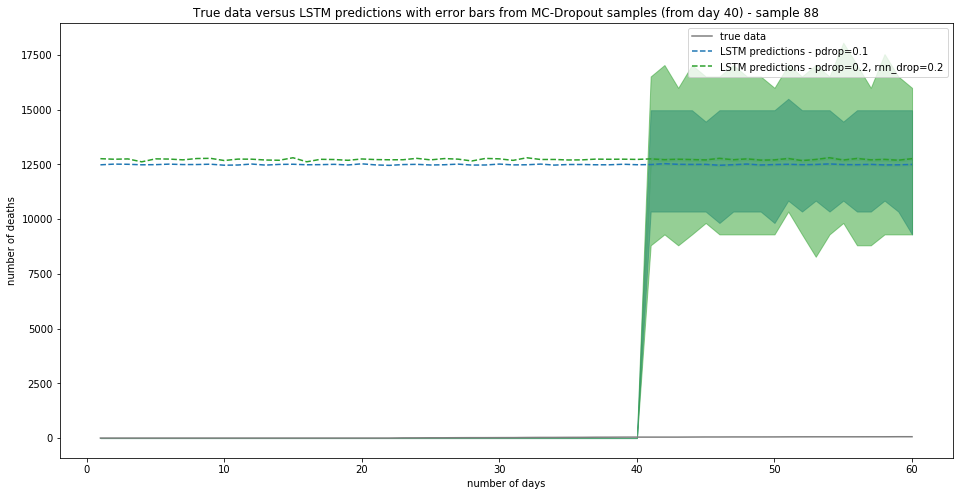

In [206]:
fig, ax = plot_mc_dropout(title, x, true_labels, lstm_preds_1, ci_1, int_1, lstm_preds_2, ci_2, int_2, lstm_preds_5, ci_5, int_5)

In [1011]:
fig_path = os.path.join(lstm_out_path_1, 'lstm_preds_sample_{}'.format(index))
fig.savefig(fig_path)